# Image reconstruction using Poutyne

In this example, we train a simple convolutional autoencoder (Conv-AE) on the MNIST dataset to learn image reconstruction. The Conv-AE is composed of two parts: an encoder and a decoder. The encoder encodes the input images to extract compact image features. The decoder, on the other hand, decodes the extracted features to reconstruct the input images.

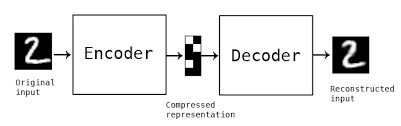

In [ ]:
%pip install poutyne

Let’s import all the needed packages.

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import math
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as tfms
from torchvision.utils import make_grid

import poutyne
from poutyne import set_seeds, Model, Experiment, ModelCheckpoint, CSVLogger

## Training constants

In [ ]:
num_epochs = 3
learning_rate = 0.001
batch_size = 32
image_size = 224
valid_split_percent = 0.2
momentum = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The running processor is...', device)
set_seeds(42)

The running processor is... cuda


## Loading the MNIST dataset

The MNIST dataset is directly downloaded from the `torchvision.datasets`. The training dataset contains 60,000 images of digits of size 28x28. However, we separate 20% of the full train dataset as a validation dataset. On the other hand, by setting the "train" argument to `False`, the test dataset containing 10,000 images is downloaded and saved in the "datasets" directory.

In [ ]:
full_train_dataset = datasets.MNIST('./datasets/', train=True, download=True, transform=tfms.ToTensor())
test_dataset = datasets.MNIST('./datasets/', train=False, download=True, transform=tfms.ToTensor())

# Selecting and seperating a proportion of the full_train_dataset to create the validation dataset.
full_dataset_length = len(full_train_dataset)
indices = list(np.arange(full_dataset_length))
np.random.shuffle(indices)
train_indices = indices[math.floor(full_dataset_length * valid_split_percent):]
valid_indices = indices[:math.floor(full_dataset_length * valid_split_percent)]

train_dataset = Subset(full_train_dataset, train_indices)
valid_dataset = Subset(full_train_dataset, valid_indices)

The format of the downloaded MNIST dataset is proper for a classification application, which means each sample is composed of an image and a label (the digit drawn in the image). However, for image reconstruction, the dataset should contain an input image and a target image, which simply are the same. Hence, using the code below, we define a new dataset that wraps an MNIST dataset and provides an image as an input and sets that image as its target, as well. In other words, we change the format of each dataset sample, from (image, label) to the (image, image).

In [ ]:
class ImageReconstructionDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset
          
    def __getitem__(self, index):
        input_image = self.dataset[index][0]
        reconstructed_image = input_image  # In image reconstruction, input and target images are the same.
          
        return input_image, reconstructed_image
      
    def __len__(self):
          
        return len(self.dataset)   

Finally, in the section below, we wrap the MNIST datasets into our wrapper and create dataloaders for them.

In [ ]:
train_dataset_new = ImageReconstructionDataset(train_dataset)
valid_dataset_new = ImageReconstructionDataset(valid_dataset)
test_dataset_new = ImageReconstructionDataset(test_dataset)

train_dataloader = DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset_new, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset_new, batch_size=1, shuffle=False)

## Convolutional autoencoder

In [ ]:
class ConvAutoencoder(nn.Module):

    def __init__(self):
        super(ConvAutoencoder, self).__init__()
      
        #encoder
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
      
        #decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        x = torch.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
              
        return x

network = ConvAutoencoder()
print(network)

ConvAutoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)


In order to interact with the optimization process, <a href="https://poutyne.org/callbacks.html"> callbacks</a> are defined and saved using the code below which saves the last weights, best weights and the logs, respectively.

In [ ]:
#callbacks

save_path = 'saves'

# Creating saving directory 
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_weights.ckpt')),

    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(os.path.join(save_path, 'best_weight.ckpt'),
                    save_best_only=True, restore_best=True, verbose=True),

    # Save the losses for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

In [ ]:
# specifying loss and optimization function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

## Training

In [ ]:
# Poutyne Model on GPU
model = Model(network, optimizer, criterion, device=device)

# Train
model.fit_generator(train_dataloader, valid_dataloader, epochs=num_epochs, callbacks=callbacks)

Epoch: 1/3 Train steps: 1500 Val steps: 375 14.26s loss: 0.034687 val_loss: 0.016448
Epoch 1: val_loss improved from inf to 0.01645, saving file to saves/best_weight.ckpt
Epoch: 2/3 Train steps: 1500 Val steps: 375 14.14s loss: 0.015051 val_loss: 0.014117
Epoch 2: val_loss improved from 0.01645 to 0.01412, saving file to saves/best_weight.ckpt
Epoch: 3/3 Train steps: 1500 Val steps: 375 14.01s loss: 0.013615 val_loss: 0.013226
Epoch 3: val_loss improved from 0.01412 to 0.01323, saving file to saves/best_weight.ckpt
Restoring model from saves/best_weight.ckpt


[{'epoch': 1,
  'loss': 0.03468729709026714,
  'time': 14.264661538000041,
  'val_loss': 0.016448105377455554},
 {'epoch': 2,
  'loss': 0.01505149643868208,
  'time': 14.136571727000046,
  'val_loss': 0.014117096416652203},
 {'epoch': 3,
  'loss': 0.013614639081681769,
  'time': 14.009871964000013,
  'val_loss': 0.013225818981726964}]

## A random batch of the MNIST dataset images

Let's see some of the input samples, inside the training dataset.

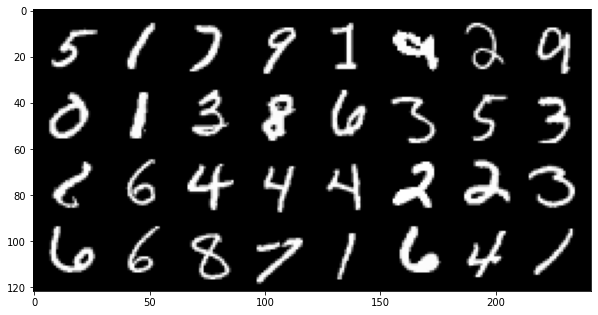

In [ ]:
inputs = next(iter(train_dataloader))[0]
input_grid = make_grid(inputs)
fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))
plt.imshow(inp)
plt.show()

## Reconstructed images after 3 epochs of training

In order to visually evaluate the quality of the results, here, we show the reconstruction results of the samples shown above.

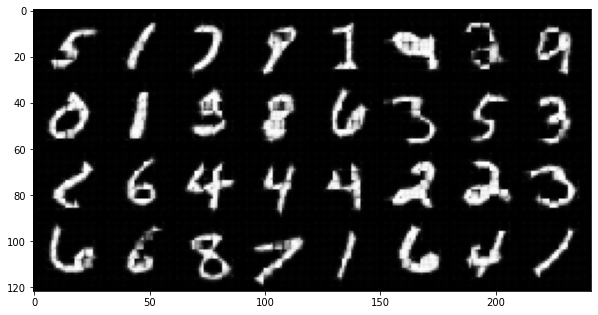

In [ ]:
# Calculating predictions of the trained network on a batch
outputs = torch.tensor(model.predict_on_batch(inputs))
output_grid = make_grid(outputs)
fig = plt.figure(figsize=(10, 10))
out = output_grid.numpy().transpose((1, 2, 0))
plt.imshow(out)
plt.show()

## Evaluation

One of the strong and useful tools in Poutyne is the evaluate methods, which not only provide you with the evaluation metrics but also provide the ground truths and the predictions if the related arguments have been set to True (as below).

In [ ]:
# evaluating thetrained network on test data
loss, predictions, ground_truth = model.evaluate_generator(test_dataloader, return_pred=True, return_ground_truth=True)

Test steps: 10000 28.95s test_loss: 0.012833                                  


In most computer vision applications, such as image reconstruction, it is very important to check the network's failures (or abilities, vice versa). The following part shows an input and a reconstructed image, as well as its reconstruction error map. The reconstruction error map shows which part of the image has not been reconstructed accurately.

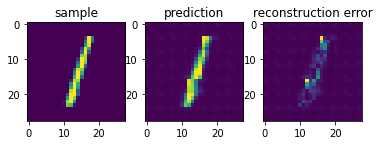

In [ ]:
sample_number = 2   # a sample from test dataset

sample = ground_truth[sample_number][0]
sample_prediction_result_3epochs = predictions[sample_number][0]

recunstruction_error_map_3epochs = sample - sample_prediction_result_3epochs  #reconstruction error map
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(sample)
ax1.set_title('sample')

ax2.imshow(sample_prediction_result_3epochs)
ax2.set_title('prediction')

ax3.imshow(np.abs(recunstruction_error_map_3epochs))
ax3.set_title('reconstruction error')
plt.show()

## Resuming the training for more epochs

If we find the past epochs not enough, Poutyne allows you to resume the training from the last done epoch, as below:

In [ ]:
model.fit_generator(train_dataloader, valid_dataloader, epochs=13, callbacks=callbacks, initial_epoch=num_epochs)

## Reconstructed images after the second training process

Now let's visualize the quality of the results after the second phase of training.

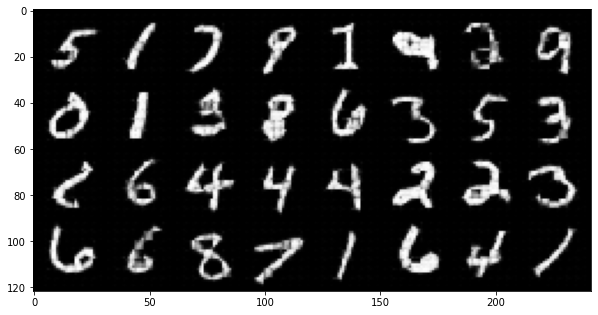

In [ ]:
outputs = torch.tensor(model.predict_on_batch(inputs))
output_grid = make_grid(outputs)
fig = plt.figure(figsize=(10, 10))
out = output_grid.numpy().transpose((1, 2, 0))
plt.imshow(out)
plt.show()

In [ ]:
loss, predictions, ground_truth = model.evaluate_generator(test_dataloader, return_pred=True, return_ground_truth=True)

Test steps: 10000 29.13s test_loss: 0.010227                                  


Here, we compare the reconstruction accuracy of the network after 3 epochs and 13 epochs of training.

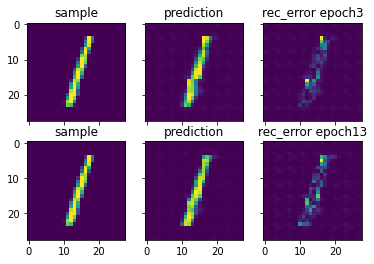

In [ ]:
sample_number = 2 
sample = ground_truth[sample_number][0]
sample_prediction_result_13epochs = predictions[sample_number][0]
recunstruction_error_map_13epochs = sample - sample_prediction_result_13epochs  #reconstruction error map

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
axs[0, 0].imshow(sample)
axs[0, 0].set_title('sample')

axs[0, 1].imshow(sample_prediction_result_3epochs)
axs[0, 1].set_title('prediction')

axs[0, 2].imshow(np.abs(recunstruction_error_map_3epochs))
axs[0, 2].set_title('rec_error epoch3')

axs[1, 0].imshow(sample)
axs[1, 0].set_title('sample')

axs[1, 1].imshow(sample_prediction_result_13epochs)
axs[1, 1].set_title('prediction')

axs[1, 2].imshow(np.abs(recunstruction_error_map_13epochs))
axs[1, 2].set_title('rec_error epoch13')

plt.show()

You can also try more finetuning, by changing the hyperparameters (network capacity, epochs, etc) to increase the accuracy as much as you want.